In [2]:
# Extra Setup for Colaboratory Environment

#!pip install cmake
#!pip install dlib

#from google.colab import files
#uploaded = files.upload() 

#!7za e colaboratory_dependencies.7z
#!7za x frontalization_models.7z
#!7za x dlib_models.7z

In [3]:
'''
Libraries, etc.
'''
import os
import sys
import cv2
import numpy as np 
import scipy as sp
import pandas as pd 
import seaborn as sns
from math import sqrt
import scipy.io as io
import tensorflow as tf 
from pathlib import Path
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.utils import np_utils as npu
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Convolution2D, Activation, BatchNormalization, GaussianNoise, MaxPooling2D, Dropout, Dense, Flatten

import frontalize
import check_resources as check
import camera_calibration as calib
import facial_feature_detector as feature_detection

from models import get_model1, get_model2, get_model3

#this_path = os.path.dirname(os.path.abspath(__file__)) 
this_path = str(Path().resolve()) # for Colaboratory

Using TensorFlow backend.


In [13]:
'''
Constants, Hyperparameters, etc.
'''
BATCH_SIZE = 128
NUM_EPOCHS = 64

input_file = 'fer2013.csv'
filepath = 'Model.{epoch:02d}-{val_acc:.4f}.hdf5'

model1_acc_file = "acc_model1_t2.png"
model2_acc_file = "acc_model2_t2.png"
model3_acc_file = "acc_model3_t2.png"
acc_file = model1_acc_file

model1_loss_file = "loss_model1_t2.png"
model2_loss_file = "loss_model2_t2.png"
model3_loss_file = "loss_model3_t2.png"
loss_file = model1_loss_file

model1_cm_file = "cm_model1_t2.png"
model2_cm_file = "cm_model2_t2.png"
model3_cm_file = "cm_model3_t2.png"
cm_file = model1_cm_file

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [5]:
'''
Load & Parse Data into Training/Test Labels & Images
'''
data = pd.read_csv(input_file)
data.head()

# get data and labels
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

# greyscale so depth 1
depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

# from pandas to np array
X_train = np.array(list(map(str.split, train_set.pixels)), np.uint8)
X_validation = np.array(list(map(str.split, validation_set.pixels)), np.uint8)
X_test = np.array(list(map(str.split, test_set.pixels)), np.uint8)

# reshape data
num_train = X_train.shape[0]
num_validation = X_validation.shape[0]
num_test = X_test.shape[0]

X_train = X_train.reshape(num_train, width, height, depth)
X_validation = X_validation.reshape(num_validation, width, height, depth)
X_test = X_test.reshape(num_test, width, height, depth)

y_train = train_set.emotion
y_validation = validation_set.emotion
y_test = test_set.emotion

y_train = np_utils.to_categorical(y_train, num_classes)
y_validation = np_utils.to_categorical(y_validation, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print shapes
print('X_training: ', X_train.shape)
print('X_validation: ', X_validation.shape)
print('X_test: ', X_test.shape)
print( )
print('y_training: ', y_train.shape)
print('y_validation: ', y_validation.shape)
print('y_test: ', y_test.shape)

X_training:  (28709, 48, 48, 1)
X_validation:  (3589, 48, 48, 1)
X_test:  (3589, 48, 48, 1)

y_training:  (28709, 7)
y_validation:  (3589, 7)
y_test:  (3589, 7)


In [6]:
'''
Frontalization Function
'''
def myfrontalize(X, limit=0):
  count = 0

  if (limit == 0):
    limit = X.shape[0]
    
  print("Total Images: ", limit)
    
  # check for dlib saved weights for face landmark detection
  # if it fails, dowload and extract it manually from
  # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
  check.check_dlib_landmark_weights()
    
  # load detections performed by dlib library on 3D model and Reference Image
  model3D = frontalize.ThreeD_Model(this_path + "/frontalization_models/model3Ddlib.mat", 'model_dlib')
  
  # load mask to exclude eyes from symmetry
  eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
        
  for i in range(0, limit):
    print("\r", end='')
    print("Images Completed: {0}".format(i), end='', flush=True)

    # cast img to type int for cv2
    img = X[i, :, :, 0].astype(np.uint8)
    
    # create a color version for frontalizer stuffs
    c_img = np.copy(img)
    c_img = cv2.cvtColor(c_img, cv2.COLOR_GRAY2BGR)    
    
    # extract landmarks from the query image
    # list containing a 2D array with points (x, y) for each face detected in the query image
    lmarks = feature_detection.get_landmarks(c_img)
    if type(lmarks) is np.ndarray:
      
      # perform camera calibration according to the first face detected
      proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
      
      # perform frontalization and convert result to grayscale
      frontal_raw, frontal_sym = frontalize.frontalize(c_img, proj_matrix, model3D.ref_U, eyemask)
      temp = cv2.cvtColor(frontal_raw, cv2.COLOR_BGR2GRAY)
    
      # find nonzero bbox and crop image to remove uncessesary black space from edges           
      temp_mask = cv2.findNonZero(temp)     
      t_x, t_y, t_w, t_h = cv2.boundingRect(temp_mask)
      t_bbox = temp[t_y:t_y+t_h, t_x:t_x+t_w]

      # resize the cropped image to the appropriate dimensions for network
      t_bbox = cv2.resize(t_bbox, dsize=(48, 48))  
      t_bbox = np.resize(t_bbox, (48, 48, 1))   
      X[i] = t_bbox.astype(np.float32)
    
      plt.show()
      count += 1
      
  print( )
  print('{} images out of {} were frontalized.'.format(count, limit))

Total Images:  28698
Images Completed: 28697
19984 images out of 28698 were frontalized.
Total Images:  3589
Images Completed: 3588
2487 images out of 3589 were frontalized.
Total Images:  3589
Images Completed: 3588
2471 images out of 3589 were frontalized.
Original Images


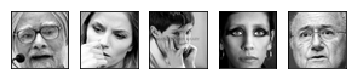

Original w/ Linear Transform to normalize pixel values


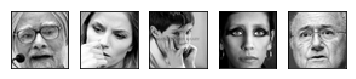

Normalized w/ Contrast Limited Adaptive Histogram Equalization


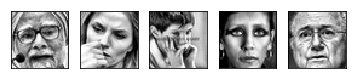

Frontalized Images


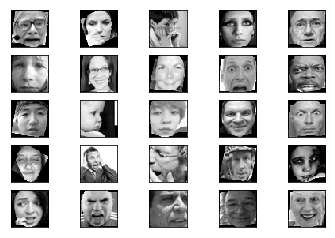

In [7]:
'''
Histogram Equalization - Not defined as method, because 
train has a special case to catch and delete harmful inputs
'''
clahe = cv2.createCLAHE(clipLimit=3.235, tileGridSize=(5,5))

# original image set
X_train1 = X_train.copy().astype(np.uint8)
X_val1 = X_validation.copy().astype(np.uint8)
X_test1 = X_test.copy().astype(np.uint8)

# linear histogram equalization set
X_train2 = X_train1.copy() 
X_val2 = X_val1.copy()
X_test2 = X_test1.copy()

# clahe set
X_train3 = X_train1.copy()
X_val3 = X_val1.copy()
X_test3 = X_test1.copy()

# frontalized set
X_train4 = X_train1.copy()
X_val4 = X_val1.copy()
X_test4 = X_test1.copy()

# histogram equalization
i = 0
while (i < num_train):
  tMax = X_train1[i].max()
  tMin = X_train1[i].min()  

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_train2[i] = np.multiply((X_train1[i] - tMin), tRatio)
    X_train3[i] = clahe.apply(X_train2[i])[:,:,np.newaxis]
    i += 1
    
  # Delete harmful training examples from X_train
  else:
    X_train1 = np.delete(X_train1, (i), axis=0)
    X_train2 = np.delete(X_train2, (i), axis=0)
    X_train3 = np.delete(X_train3, (i), axis=0)
    X_train4 = np.delete(X_train4, (i), axis=0)
    y_train = np.delete(y_train, (i), axis=0)
    num_train -= 1
  
i = 0
while (i < num_validation):
  tMax = X_val1[i].max()
  tMin = X_val1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_val2[i] = np.multiply((X_val1[i] - tMin), tRatio).round()
    
  # Shouldn't delete validation data... skip so we don't divide by 0
  else:
    X_val2[i] = X_val1[i]

  X_val3[i] = clahe.apply(X_val2[i])[:,:,np.newaxis]
  i += 1

i = 0
while (i < num_test):
  tMax = X_test1[i].max()
  tMin = X_test1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_test2[i] = np.multiply((X_test1[i] - tMin), tRatio).round()
    
  # Shouldn't delete test data... skip so we don't divide by 0
  else:
    X_test2[i] = X_test1[i]
    
  X_test3[i] = clahe.apply(X_test2[i])[:,:,np.newaxis]
  i += 1
  
# apply frontalization
#print("Attempting to frontalize image data...")
#myfrontalize(X_train4, num_train)
#np.save('X_train_frontalized', X_train4)

#myfrontalize(X_val4, num_validation)
#np.save('X_val_frontalized', X_val4)

#myfrontalize(X_test4, num_test)
#np.save('X_test_frontalized', X_test4)

X_train4 = np.load('X_train_frontalized.npy')
X_val4 = np.load('X_val_frontalized.npy')
X_test4 = np.load('X_test_frontalized.npy')


# print examples from each set
print('Original Images')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train1[x,:,:,0], cmap='gray') 
plt.show()

print('Original w/ Linear Transform to normalize pixel values')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train2[x,:,:,0], cmap='gray')   
plt.show()

print('Normalized w/ Contrast Limited Adaptive Histogram Equalization')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train3[x,:,:,0], cmap='gray')    
plt.show() 

print('Frontalized Images')
for x in range(1,26):
  plt.subplot(5, 5, x)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train4[x, :, :, 0], cmap='gray') 
    
plt.show()

In [8]:
'''
TensorFlow Model(s)
'''

# shallow model
def get_model1():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# actual model
def get_model2():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# deeper model
def get_model3():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Convolution2D(64, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(Convolution2D(128, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(Convolution2D(265, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(Convolution2D(512, (3, 3), padding='same')) 
  model.add(Convolution2D(512, (1, 1), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  #model.add(GaussianNoise(2))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(2048))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

In [9]:
'''
Metric(s)
'''

# metric to balance precision and recall
def fbeta(y_true, y_pred, threshold_shift=0):
  beta = 1

  # just in case of hipster activation at the final layer
  y_pred = K.clip(y_pred, 0, 1)

  # shifting the prediction threshold from .5 if needed
  y_pred_bin = K.round(y_pred + threshold_shift)

  tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
  fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  beta_squared = beta ** 2
  return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))


In [19]:
'''
Prepare Model for Training
'''
# assign the desired model from above
model = get_model3()
model.summary()

# assign X to the desired image set(s) from above
X_train = X_train4.copy()
X_validation = X_val4.copy()
X_test = X_test4.copy()

num_train = len(X_train)

# reshape X to expected shape and cast it back to type float32
X_train = X_train.reshape(num_train,width,height,depth).astype(np.float32)
X_validation = X_validation.reshape(num_validation,width,height,depth).astype(np.float32)
X_test = X_test.reshape(num_test,width,height,depth).astype(np.float32)

# augment and fit data
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)
datagen.fit(X_validation)

# to be applied during training
checkpointer = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, 
    patience=10, verbose=0, mode='auto', 
    min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, 
    verbose=0, mode='auto')

# prepare model to train
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_22 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)       73856     
__________

In [20]:
'''
Training
'''
train_flow = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_flow = datagen.flow(X_validation, y_validation)

history = model.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

Epoch 1/64
225/224 [==============================] - 17s 76ms/step - loss: 1.9901 - fbeta: 0.0340 - acc: 0.2308 - val_loss: 1.7834 - val_fbeta: 1.9971e-07 - val_acc: 0.2705

Epoch 00001: saving model to Model.01-0.2705.hdf5

Epoch 00001: saving model to Model.01-0.2705.hdf5
Epoch 2/64
225/224 [==============================] - 14s 62ms/step - loss: 1.6891 - fbeta: 0.1239 - acc: 0.3521 - val_loss: 2.2985 - val_fbeta: 0.2478 - val_acc: 0.2683

Epoch 00002: saving model to Model.02-0.2683.hdf5

Epoch 00002: saving model to Model.02-0.2683.hdf5
Epoch 3/64
225/224 [==============================] - 14s 62ms/step - loss: 1.4803 - fbeta: 0.2129 - acc: 0.4317 - val_loss: 1.4702 - val_fbeta: 0.2457 - val_acc: 0.4397

Epoch 00003: saving model to Model.03-0.4397.hdf5

Epoch 00003: saving model to Model.03-0.4397.hdf5
Epoch 4/64
225/224 [==============================] - 14s 62ms/step - loss: 1.3360 - fbeta: 0.2679 - acc: 0.4874 - val_loss: 1.2558 - val_fbeta: 0.3918 - val_acc: 0.5405

Epoch 000

225/224 [==============================] - 14s 62ms/step - loss: 0.9298 - fbeta: 0.5155 - acc: 0.6467 - val_loss: 1.0088 - val_fbeta: 0.5032 - val_acc: 0.6024

Epoch 00031: saving model to Model.31-0.6024.hdf5

Epoch 00031: saving model to Model.31-0.6024.hdf5
Epoch 32/64
225/224 [==============================] - 14s 62ms/step - loss: 0.9172 - fbeta: 0.5260 - acc: 0.6520 - val_loss: 1.0024 - val_fbeta: 0.5327 - val_acc: 0.6226

Epoch 00032: saving model to Model.32-0.6226.hdf5

Epoch 00032: saving model to Model.32-0.6226.hdf5
Epoch 33/64
225/224 [==============================] - 14s 62ms/step - loss: 0.9151 - fbeta: 0.5262 - acc: 0.6543 - val_loss: 1.0082 - val_fbeta: 0.4871 - val_acc: 0.6131

Epoch 00033: saving model to Model.33-0.6131.hdf5

Epoch 00033: saving model to Model.33-0.6131.hdf5
Epoch 34/64
225/224 [==============================] - 14s 62ms/step - loss: 0.9025 - fbeta: 0.5319 - acc: 0.6566 - val_loss: 0.9862 - val_fbeta: 0.5259 - val_acc: 0.6401

Epoch 00034: saving m

Epoch 61/64
225/224 [==============================] - 14s 62ms/step - loss: 0.6477 - fbeta: 0.6790 - acc: 0.7555 - val_loss: 0.9652 - val_fbeta: 0.5862 - val_acc: 0.6627

Epoch 00061: saving model to Model.61-0.6627.hdf5

Epoch 00061: saving model to Model.61-0.6627.hdf5
Epoch 62/64
225/224 [==============================] - 14s 62ms/step - loss: 0.6430 - fbeta: 0.6820 - acc: 0.7574 - val_loss: 1.0645 - val_fbeta: 0.5657 - val_acc: 0.6390

Epoch 00062: saving model to Model.62-0.6390.hdf5

Epoch 00062: saving model to Model.62-0.6390.hdf5
Epoch 63/64
225/224 [==============================] - 14s 63ms/step - loss: 0.6366 - fbeta: 0.6859 - acc: 0.7595 - val_loss: 0.9585 - val_fbeta: 0.5971 - val_acc: 0.6582

Epoch 00063: saving model to Model.63-0.6582.hdf5

Epoch 00063: saving model to Model.63-0.6582.hdf5
Epoch 64/64
225/224 [==============================] - 14s 63ms/step - loss: 0.6309 - fbeta: 0.6877 - acc: 0.7602 - val_loss: 0.9925 - val_fbeta: 0.5765 - val_acc: 0.6498

Epoch 000

28/28 [==============================] - 14s 504ms/step
Evaluation Loss:  0.9413670897483826
Evaluation Accuracy:  0.6171635389328003


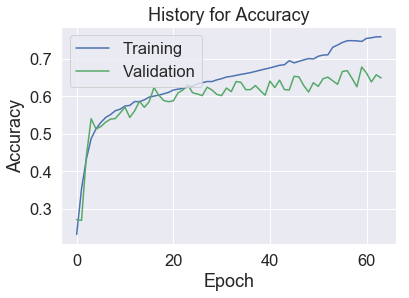

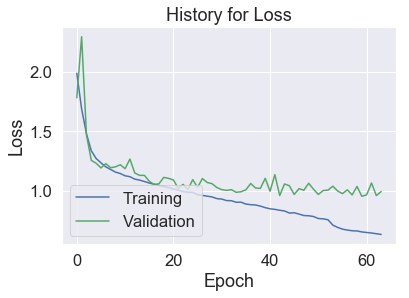

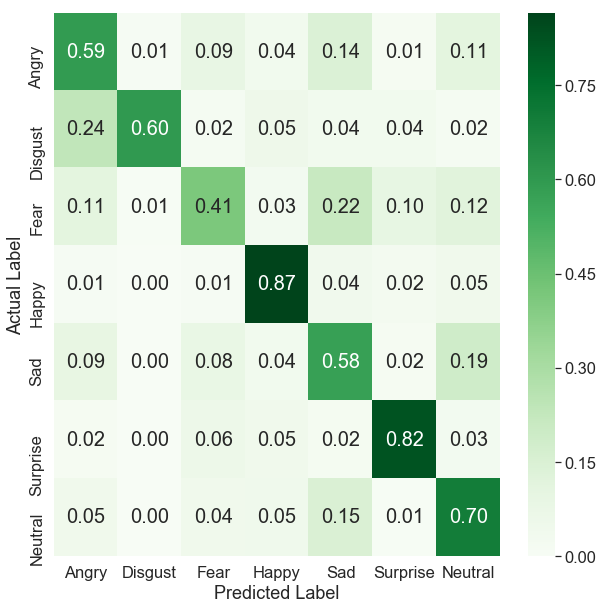

In [21]:
'''
Evaluate Test Set & Print Results
'''
score = model.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Evaluation Loss: ', score[0])
print('Evaluation Accuracy: ', score[1])

# History of Accuracy
fig1 = plt.figure()
plt.plot(history.history['acc'], color='b', label='Training')
plt.plot(history.history['val_acc'], color='g', label='Validation')
plt.title('History for Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 

# History of Loss
fig2 = plt.figure()
plt.plot(history.history['loss'], color='b', label='Training')
plt.plot(history.history['val_loss'], color='g', label='Validation')
plt.title('History for Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
fig2.savefig(loss_file)
plt.show()

# Confusion Matrix
y_pred = model.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()